In [1]:
# Import necessary packages and load ENDF data
import sys
sys.path.append('/home/pierre/codes/NuclearDataSampler/src')

import numpy as np
import ENDFtk
import matplotlib.pyplot as plt

# Reload modules to get latest changes
if 'ndsampler.energy.Parameters_Energydist' in sys.modules:
    del sys.modules['ndsampler.energy.Parameters_Energydist']
if 'ndsampler.energy.Uncertainty_Energydist' in sys.modules:
    del sys.modules['ndsampler.energy.Uncertainty_Energydist']
if 'ndsampler.energy.EnergyDistributionCovariance' in sys.modules:
    del sys.modules['ndsampler.energy.EnergyDistributionCovariance']
if 'ndsampler.energy' in sys.modules:
    del sys.modules['ndsampler.energy']

from ndsampler.energy.Uncertainty_Energydist import Uncertainty_Energydist

# Load JEFF-4.0 U-235 data
endf_file = '/home/pierre/Projects/LIB/JEFF40/n_92-U-235g.jeff'
tape = ENDFtk.tree.Tape.from_file(endf_file)
mat = tape.material(tape.material_numbers[0])

mf5mt18 = mat.MF(5).MT(18).parse()
mf35mt18 = mat.MF(35).MT(18).parse()

print(f"Material: {mat.MAT}")
print(f"MF5 MT18: {mf5mt18.number_partial_distributions} partial distributions")
print(f"MF35 MT18: {mf35mt18.number_energy_blocks} covariance blocks")
print("\n✓ Data loaded successfully")

Material: 9228
MF5 MT18: 1 partial distributions
MF35 MT18: 8 covariance blocks

✓ Data loaded successfully


Creating energy distribution uncertainty for MT18...

Creating distributions for covariance blocks:
  Block 0: [0.0000e+00, 1.0000e+03] eV - using incident E = 1.0000e-05 eV (index 0)
    Integrated probs: sum_before=1.005077, sum_after=1.000000
    Range: [1.967910e-17, 1.777729e-02]
  Block 1: [1.0000e+03, 1.0000e+05] eV - using incident E = 1.0000e+03 eV (index 2)
    Integrated probs: sum_before=0.818008, sum_after=1.000000
    Range: [2.417924e-17, 2.208935e-01]
  Block 2: [1.0000e+05, 1.0000e+06] eV - using incident E = 1.0000e+05 eV (index 5)
    Integrated probs: sum_before=0.818077, sum_after=1.000000
    Range: [2.415969e-17, 2.209053e-01]
  Block 3: [1.0000e+06, 5.0000e+06] eV - using incident E = 1.0000e+06 eV (index 9)
    Integrated probs: sum_before=0.818732, sum_after=1.000000
    Range: [2.397733e-17, 2.210028e-01]
  Block 4: [5.0000e+06, 1.0000e+07] eV - using incident E = 5.0000e+06 eV (index 25)
    Integrated probs: sum_before=0.821931, sum_after=1.000000
    Range

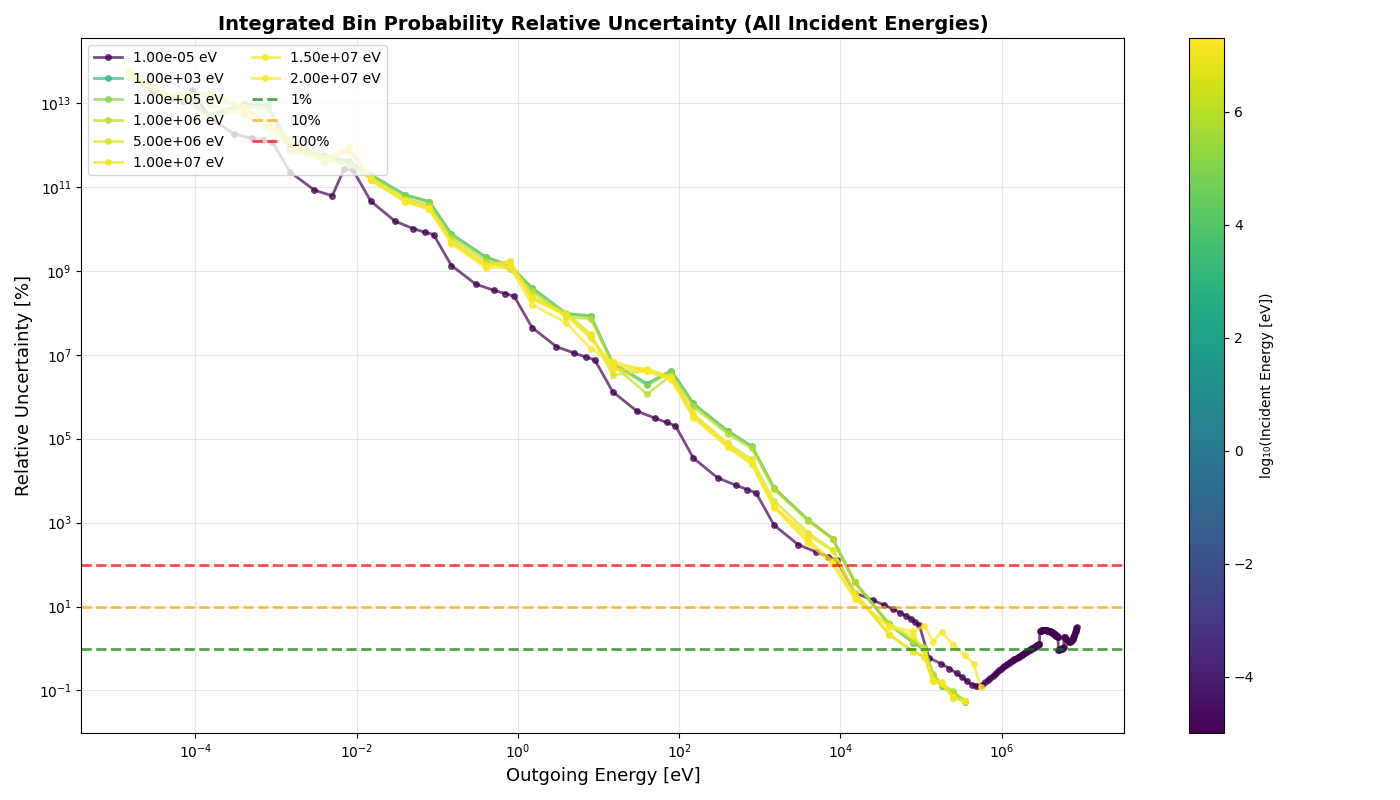


✓ Plot complete

Note: Relative uncertainty = (absolute_std / integrated_probability) × 100%
      where integrated_probability is the bin-integrated yield (dimensionless, sums to 1.0)


In [2]:
# Create uncertainty object and plot superposed relative uncertainties
%matplotlib widget

# Create uncertainty object
uncertainty = Uncertainty_Energydist(mf5mt18, mf35mt18, mt_number=18)

print(f"\n✓ Created {len(uncertainty.energy_data.distributions)} distributions")
print(f"  Covariance matrix size: {uncertainty.L_matrix.shape}")

# Get expected standard deviations from covariance matrix
expected_cov = uncertainty.L_matrix @ uncertainty.L_matrix.T
expected_std = np.sqrt(np.diag(expected_cov))

# Extract relative uncertainties for each distribution
all_incident_energies = []
all_rel_uncertainties = []
all_bin_centers = []

print("\nProcessing distributions:")
print("=" * 80)

for dist in uncertainty.energy_data.distributions:
    # Find covariance indices for this distribution
    cov_indices = [i for i, (inc_idx, _, _, _) in enumerate(uncertainty.covariance_index_map) 
                   if inc_idx == dist.incident_energy_index]
    
    if len(cov_indices) > 0:
        # Get absolute standard deviations from covariance
        std_for_dist = expected_std[cov_indices]
        
        # Get nominal INTEGRATED probabilities (these should sum to ~1.0)
        nominal_integrated_probs = np.array(dist.probabilities[0])[:len(std_for_dist)]
        
        print(f"\nIncident E = {dist.incident_energy:.4e} eV (index {dist.incident_energy_index}):") 
        print(f"  N_bins: {len(nominal_integrated_probs)}")
        print(f"  Sum of integrated probs: {nominal_integrated_probs.sum():.6f}")
        print(f"  Integrated prob range: [{nominal_integrated_probs.min():.6e}, {nominal_integrated_probs.max():.6e}]")
        print(f"  Absolute std range: [{std_for_dist.min():.6e}, {std_for_dist.max():.6e}]")
        
        # Compute relative uncertainties (percent)
        rel_unc_pct = (std_for_dist / (nominal_integrated_probs + 1e-20)) * 100
        
        print(f"  Relative unc range: [{rel_unc_pct.min():.3f}%, {rel_unc_pct.max():.3f}%]")
        print(f"  Median relative unc: {np.median(rel_unc_pct):.3f}%")
        
        # Get bin centers
        outgoing_energies = dist.outgoing_energies
        bin_centers = [(outgoing_energies[i] + outgoing_energies[i+1])/2 
                       for i in range(len(std_for_dist))]
        
        all_incident_energies.append(dist.incident_energy)
        all_rel_uncertainties.append(rel_unc_pct)
        all_bin_centers.append(bin_centers)

print("\n" + "=" * 80)
print(f"\n✓ Extracted relative uncertainties for {len(all_incident_energies)} incident energies")

# Plot superposed relative uncertainties
fig, ax = plt.subplots(figsize=(14, 8))

# Color map for incident energies
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.log10(min(all_incident_energies)), 
                     vmax=np.log10(max(all_incident_energies)))

# Plot each incident energy
for inc_e, rel_unc, bin_centers in zip(all_incident_energies, all_rel_uncertainties, all_bin_centers):
    color = cmap(norm(np.log10(inc_e)))
    ax.plot(bin_centers, rel_unc, '-o', color=color, alpha=0.7, 
            linewidth=2, markersize=4, label=f'{inc_e:.2e} eV')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Outgoing Energy [eV]', fontsize=13)
ax.set_ylabel('Relative Uncertainty [%]', fontsize=13)
ax.set_title('Integrated Bin Probability Relative Uncertainty (All Incident Energies)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='log₁₀(Incident Energy [eV])')

# Add reference lines
ax.axhline(1, color='green', linestyle='--', linewidth=2, alpha=0.7, label='1%')
ax.axhline(10, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='10%')
ax.axhline(100, color='red', linestyle='--', linewidth=2, alpha=0.7, label='100%')

ax.legend(fontsize=10, ncol=2, loc='upper left')
plt.tight_layout()
plt.show()

print("\n✓ Plot complete")
print(f"\nNote: Relative uncertainty = (absolute_std / integrated_probability) × 100%")
print(f"      where integrated_probability is the bin-integrated yield (dimensionless, sums to 1.0)")